In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset class

In [2]:
class MyExpDataset(Dataset):
    def __init__(self, xs, ys):
        super().__init__()
        self.xs = torch.FloatTensor(xs).reshape(-1,1)
        self.ys = torch.FloatTensor(ys).reshape(-1,1)
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

# Ideal dataset

Text(0.5, 1.0, 'My Ideal Dataset')

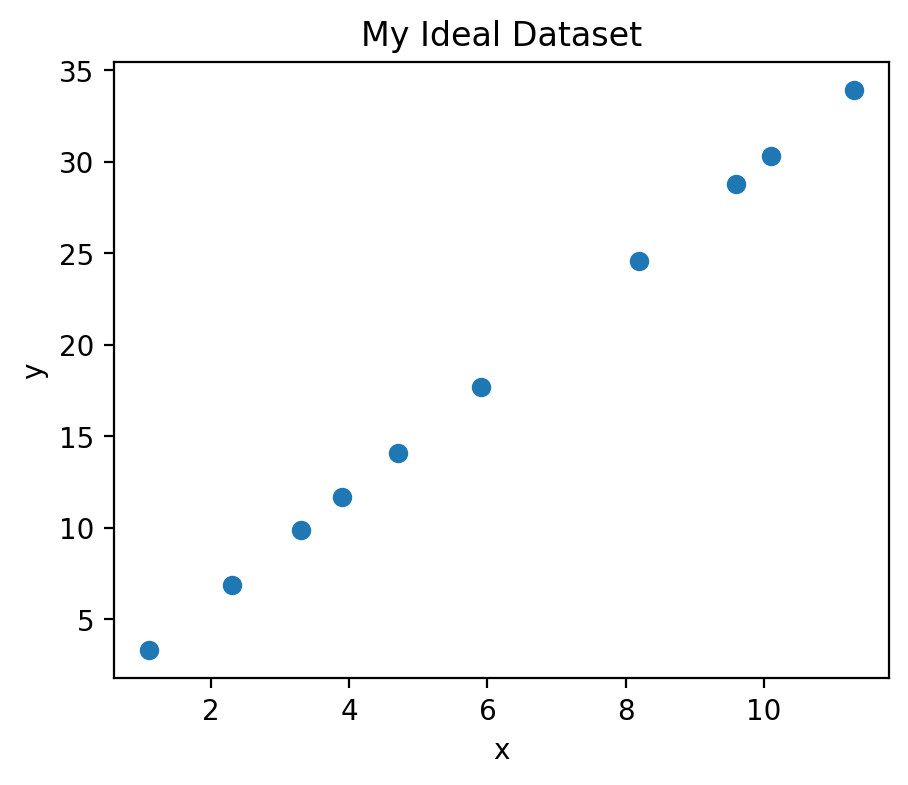

In [3]:
xs = np.array([1.1, 2.3, 3.3, 3.9, 9.6, 10.1, 11.3, 4.7, 8.2, 5.9])
ys_ideal = xs * 3

fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(xs, ys_ideal)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('My Ideal Dataset')

### Train a network

In [4]:
class DeterministicNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 1, bias=False)
    def forward(self, x):
        x = self.fc1(x)
        return x

In [5]:
ideal_ds = MyExpDataset(xs, ys_ideal)
ideal_dl = DataLoader(ideal_ds, batch_size=2, shuffle=True)

In [6]:
det_nn = DeterministicNN()
optimizer = torch.optim.SGD(det_nn.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    for x, y in ideal_dl:
        y_pred = det_nn(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Performance

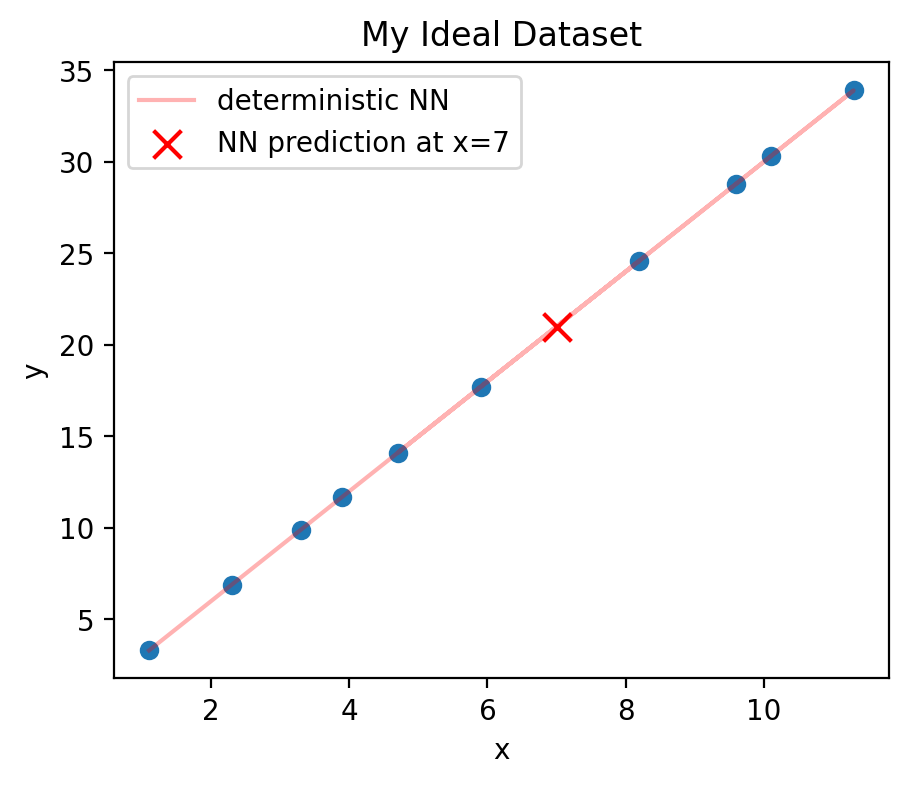

In [7]:
fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(xs, ys_ideal)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('My Ideal Dataset')

with torch.no_grad():
    y_preds = det_nn(torch.FloatTensor(xs).reshape(-1,1)).numpy()
    ax.plot(xs, y_preds, color='red', label='deterministic NN', alpha=0.3)

xs_7 = torch.FloatTensor([7.0])
y_preds_7 = det_nn(xs_7).detach().numpy()
ax.scatter(xs_7, y_preds_7, color='red', marker='x', s=100, label='NN prediction at x=7')
ax.legend()

# Realistic dataset

Text(0.5, 1.0, 'My Realistic Dataset')

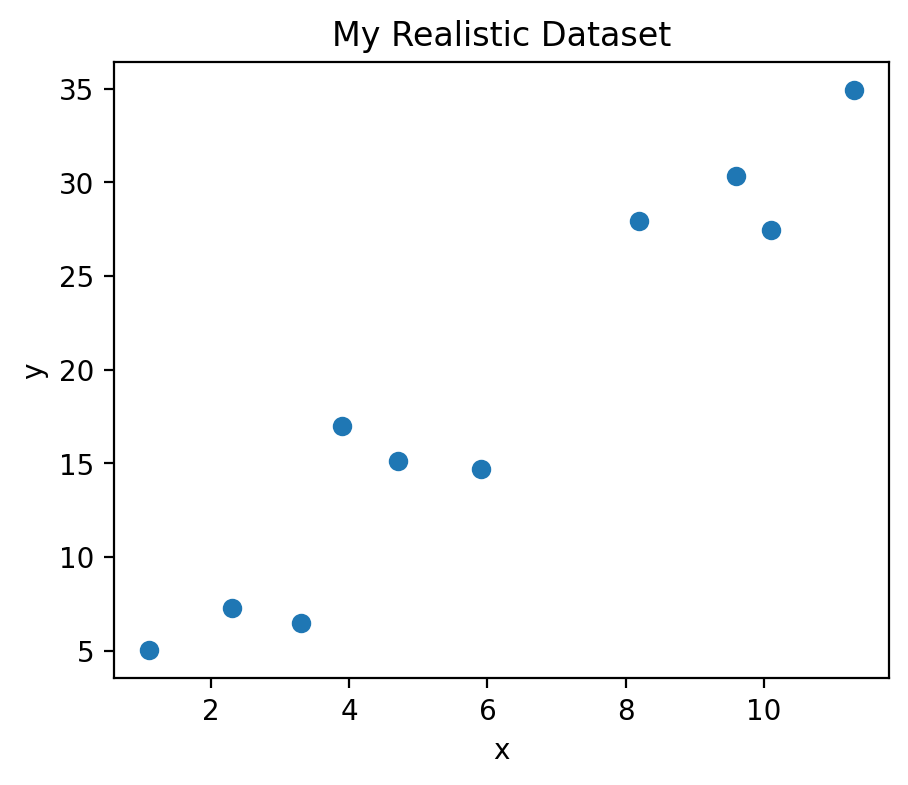

In [14]:
ys_realistic = xs * 3
ys_realistic = ys_realistic + 3*np.random.normal(0, 1, size=len(xs))

fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(xs, ys_realistic)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('My Realistic Dataset')

### training an NN

In [15]:
realistic_ds = MyExpDataset(xs, ys_realistic)
realistic_dl = DataLoader(realistic_ds, batch_size=5, shuffle=True)

In [16]:
det_nn = DeterministicNN()
optimizer = torch.optim.SGD(det_nn.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    for x, y in realistic_dl:
        y_pred = det_nn(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Performance

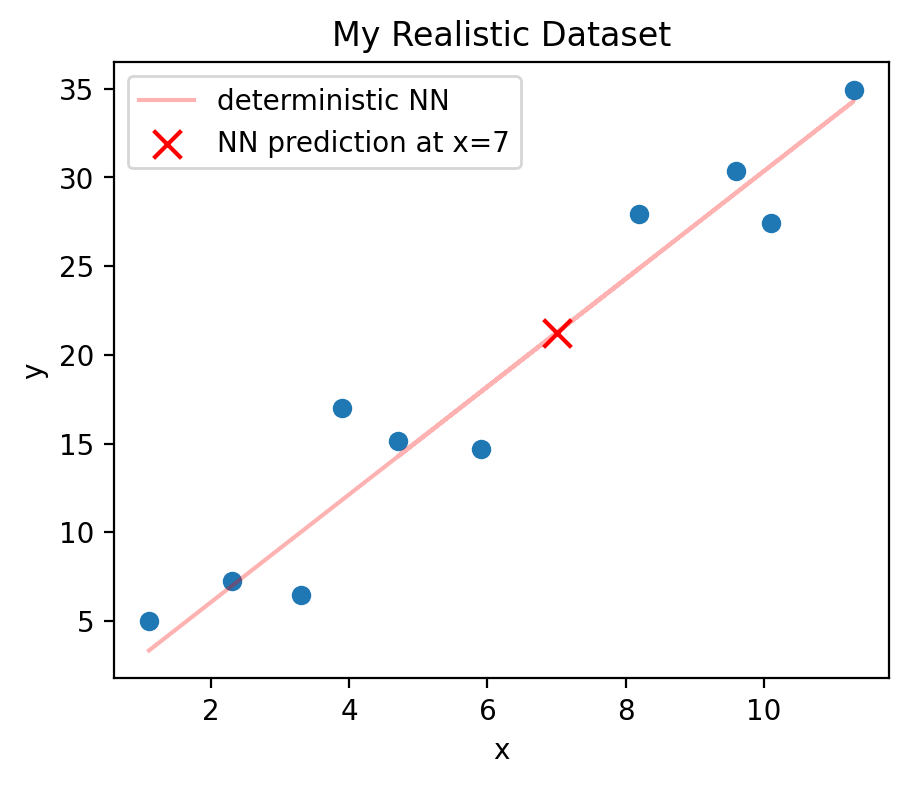

In [17]:
fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(xs, ys_realistic)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('My Realistic Dataset')

with torch.no_grad():
    y_preds = det_nn(torch.FloatTensor(xs).reshape(-1,1)).numpy()
    ax.plot(xs, y_preds, color='red', label='deterministic NN', alpha=0.3)

xs_7 = torch.FloatTensor([7.0])
y_preds_7 = det_nn(xs_7).detach().numpy()
ax.scatter(xs_7, y_preds_7, color='red', marker='x', s=100, label='NN prediction at x=7')
ax.legend()

# But we want something like this

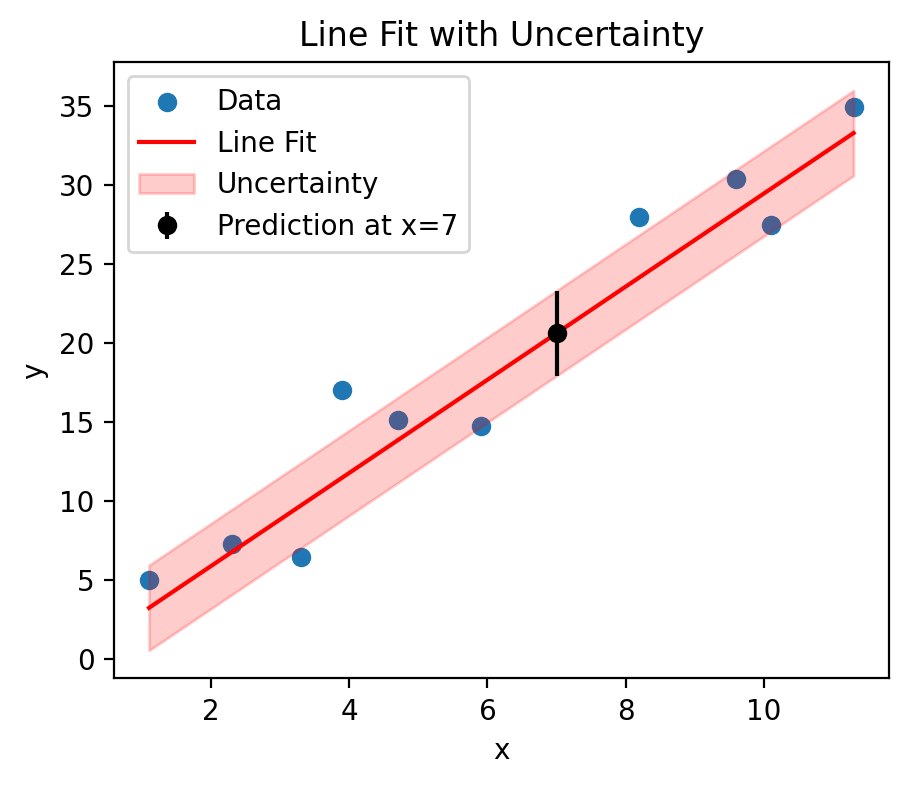

In [18]:
slope, intercept = np.polyfit(xs, ys_realistic, deg=1)

fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)

ax.scatter(xs, ys_realistic, label='Data')

x_fit = np.linspace(min(xs), max(xs), 100)
y_fit = slope * x_fit
ax.plot(x_fit, y_fit, 'r-', label='Line Fit')

x_pred = 7
y_pred = slope * x_pred

residuals = ys_realistic - (slope * xs)
std_error = np.std(residuals)

# draw an envelope around the line fit
y_upper = y_fit + std_error
y_lower = y_fit - std_error
ax.fill_between(x_fit, y_lower, y_upper, color='red', alpha=0.2, label='Uncertainty')

y_mean = y_pred
y_std = std_error

ax.errorbar(x_pred, y_mean, y_std, fmt='o', color='black', label='Prediction at x=7')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Line Fit with Uncertainty')
ax.legend()

# Enters "Pyro"

- Following the official tutorial (simplified) https://pyro.ai/examples/bayesian_regression.html
- `torch.nn.Linear(5, 7)` $\rightarrow$ `pyro.nn.PyroModule[torch.nn.Linear](5, 7)`

In [19]:
import pyro
from pyro.nn import PyroModule
import pyro.distributions as dist

### Deterministic NN

In [24]:
class PyroDeterministicNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # instead of self.fc1 = torch.nn.Linear(1, 1, bias=False)
        self.fc1 = PyroModule[nn.Linear](1, 1, bias=False)
    def forward(self, x):
        x = self.fc1(x)
        return x

In [25]:
pyro_det_nn = PyroDeterministicNN()

optimizer = torch.optim.SGD(pyro_det_nn.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    for x, y in realistic_dl:
        y_pred = pyro_det_nn(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [26]:
for name, param in pyro_det_nn.named_parameters():
    print(name, param.data.numpy())

fc1.weight [[2.9939983]]


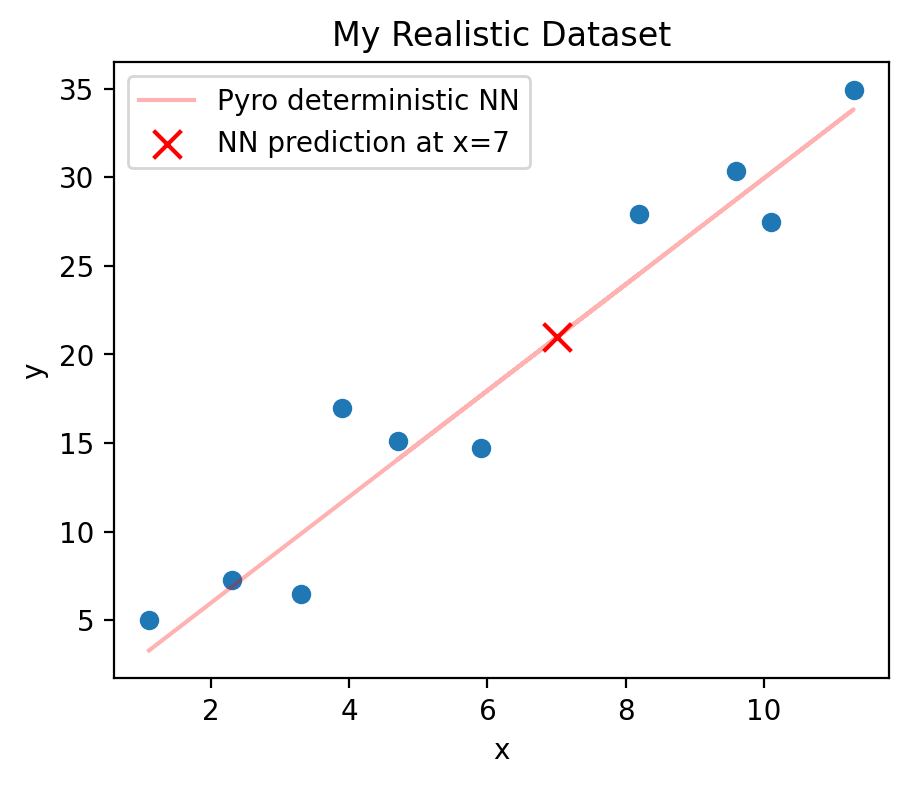

In [27]:
fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(xs, ys_realistic)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('My Realistic Dataset')

with torch.no_grad():
    y_preds = pyro_det_nn(torch.FloatTensor(xs).reshape(-1,1)).numpy()
    ax.plot(xs, y_preds, color='red', label='Pyro deterministic NN', alpha=0.3)

xs_7 = torch.FloatTensor([7.0])
y_preds_7 = pyro_det_nn(xs_7).detach().numpy()
ax.scatter(xs_7, y_preds_7, color='red', marker='x', s=100, label='NN prediction at x=7')
ax.legend()

### Let's make it Bayesian

In [30]:
from pyro.nn import PyroSample

class PyroBayesianNN(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear = PyroModule[nn.Linear](1, 1, bias=False)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([1, 1]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [31]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = PyroBayesianNN()
guide = AutoDiagonalNormal(model)

In [32]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [33]:
num_iterations = 1000
pyro.clear_param_store()
for j in range(num_iterations):
    for x_data, y_data in realistic_dl:
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data.squeeze(-1))

In [35]:
guide.requires_grad_(False)

# the mean and variace of the two parameters: nn.linear.weight and sigma
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([0.3329, 2.8494])
AutoDiagonalNormal.scale tensor([0.7177, 0.3145])


## Sampling

In [36]:
from pyro.infer import Predictive

x_pred = torch.linspace(0, 12, 100).reshape(-1, 1)

# Create a predictive function
predictive = Predictive(model, guide=guide, num_samples=100)

# Generate predictions
with torch.no_grad():
    predictions = predictive(x_pred)

# Get mean and standard deviation of the predictions
y_mean = predictions['obs'].mean(dim=0)
y_std  = predictions['obs'].std(dim=0)


# generate prediction at x=7
x_pred_7 = torch.FloatTensor([7.0])
with torch.no_grad():
    y_preds_7 = predictive(x_pred_7)

y_mean_7 = y_preds_7['obs'].mean(dim=0)
y_std_7  = y_preds_7['obs'].std(dim=0)

Text(0, 0.5, 'y')

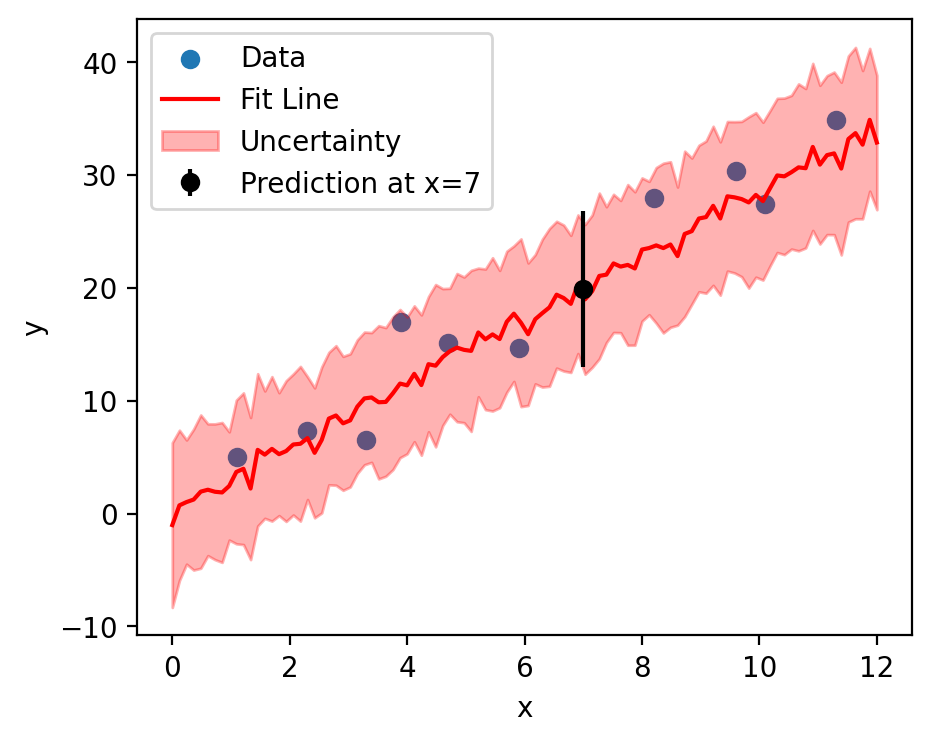

In [37]:
fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)

ax.scatter(xs, ys_realistic, label='Data')

# Plot the fit line
plt.plot(x_pred.numpy(), y_mean.numpy(), 'r', label='Fit Line')

# Plot the error envelope
plt.fill_between(
    x_pred.numpy().flatten(),
    (y_mean - y_std).numpy().flatten(),
    (y_mean + y_std).numpy().flatten(),
    color='red', alpha=0.3, label='Uncertainty'
)

# plot the prediction at x=7
ax.errorbar(x_pred_7, y_mean_7, y_std_7, fmt='o', color='black', label='Prediction at x=7')

# Add legend and labels
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')